In [1]:
from model import create_model

nn4_small2 = create_model()

/home/morteza/venvs/facenet/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
dim is deprecated, use axis instead


In [2]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))


emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [3]:
from data import triplet_generator

generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

/home/morteza/venvs/facenet/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  """


Epoch 1/10
100/100 [==============================] - 52s 521ms/step - loss: 0.8090
Epoch 2/10
100/100 [==============================] - 44s 440ms/step - loss: 0.7902
Epoch 3/10
100/100 [==============================] - 44s 438ms/step - loss: 0.8014
Epoch 4/10
100/100 [==============================] - 44s 440ms/step - loss: 0.8036
Epoch 5/10
100/100 [==============================] - 45s 454ms/step - loss: 0.8001
Epoch 6/10
100/100 [==============================] - 48s 477ms/step - loss: 0.8001
Epoch 7/10
100/100 [==============================] - 45s 451ms/step - loss: 0.7999
Epoch 8/10
100/100 [==============================] - 45s 450ms/step - loss: 0.8003
Epoch 9/10
100/100 [==============================] - 44s 436ms/step - loss: 0.8000
Epoch 10/10
100/100 [==============================] - 44s 437ms/step - loss: 0.8001


In [4]:
import numpy as np
import os.path
BASE = 'UTK/'

class RaceMetadata():
    def __init__(self, race, file):
        # image file name
        self.file = file
        # race
        self.race = race

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(BASE, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        ext = os.path.splitext(i)[1]
        race = int(i.split('_')[2])
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(RaceMetadata(race, i))
    return np.array(metadata)

metadata = load_metadata(BASE)

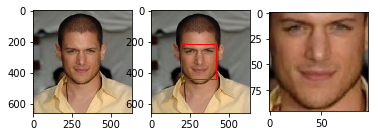

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

alignment = AlignDlib('models/landmarks.dat')
jc_orig = load_image(metadata[10].image_path())

bb = alignment.getLargestFaceBoundingBox(jc_orig)

jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

plt.subplot(131)
plt.imshow(jc_orig)

plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

plt.subplot(133)
plt.imshow(jc_aligned);

In [6]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [12]:
metadata = metadata[:3000]
embedded = np.zeros((metadata.shape[0], 128))
for i, m in enumerate(metadata):
    img_tmp = load_image(m.image_path())
    img = align_image(img_tmp)
    check = 0
    while img is None and check < 5:
        img_tmp = np.rot90(img_tmp)
        img = align_image(img_tmp)
        check+=1
    img = (img / 255.).astype(np.float32)
    embedded[i] = nn4_small2.predict(np.expand_dims(img, axis=0))[0]

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score

targets = np.array([m.race for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

X_train = embedded[train_idx]
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {0}, SVM accuracy = {1}'.format(acc_knn, acc_svc))

KNN accuracy = 0.4026666666666667, SVM accuracy = 0.49666666666666665
